In [1]:
import phyflow as pf
import phyflow.monte_carlo as mc
import phyflow.phy_flow_matching as pfm
from pathlib import Path
import torch
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
trash = []

# Increase Sample Density Lab

### Prepare the Monte Carlo data of the XY model

In [3]:
save_dir_root = './'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 16
T_start = 0.1
T_end = 2.0
precision = 0.05
ensemble_number = 1000

2025-06-14 23:13:52,099 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [4]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
)
trash.append(xy_generator)

2025-06-14 23:13:52,239 - INFO - --- Simulation Parameters for XYModel ---
2025-06-14 23:13:52,239 - INFO - Lattice size (L): 16
2025-06-14 23:13:52,239 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.05, steps: 38)
2025-06-14 23:13:52,241 - INFO - Device: cuda:0
2025-06-14 23:13:52,241 - INFO - Ensemble number per T: 1000
2025-06-14 23:13:52,241 - INFO - Number of chains (n_chains): 30
2025-06-14 23:13:52,242 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-06-14 23:13:52,242 - INFO - Calculated tau: 256.0, tau_eff: 9.6
2025-06-14 23:13:52,242 - INFO - Thermalization sweeps (n_therm): 6400 (factor: 25)
2025-06-14 23:13:52,242 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-06-14 23:13:52,242 - INFO - Production sweeps (n_sweeps): 627
2025-06-14 23:13:52,242 - INFO - -----------------------------------------------------


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=38, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


2025-06-14 23:13:52,291 - INFO - Starting Monte Carlo simulation...


Starting simulation: 6400 thermalization sweeps, 627 production sweeps.
Thermalization phase...
Production phase...


2025-06-14 23:14:09,859 - INFO - Simulation finished. Elapsed time: 17.57 s
2025-06-14 23:14:09,861 - INFO - Generated samples shape: torch.Size([38, 990, 16, 16])
2025-06-14 23:14:09,862 - INFO - Ensured directory exists: mc_data
2025-06-14 23:14:09,862 - INFO - Ensured directory exists: mc_data\XYModel
2025-06-14 23:14:09,862 - INFO - Ensured directory exists: mc_data\XYModel\field_config
2025-06-14 23:14:09,862 - INFO - Ensured directory exists: mc_data\XYModel\measurement
2025-06-14 23:14:09,864 - INFO - Saving field configurations to: mc_data\XYModel\field_config\XYModel_L16_T0_100-2_000_prec0_050_ens1000_configs.pt
2025-06-14 23:14:09,864 - INFO - Configs tensor shape: torch.Size([38, 990, 16, 16])
2025-06-14 23:14:09,864 - INFO - Labels tensor shape: torch.Size([38, 2])


Simulation finished. Collected 990 samples.
labels shape: torch.Size([38, 2])
first label pair: tensor([ 0.1000, 16.0000])


2025-06-14 23:14:10,106 - INFO - Field configurations saved.
2025-06-14 23:14:10,106 - INFO - Performing measurements...
2025-06-14 23:14:10,892 - INFO - Measurements complete.
2025-06-14 23:14:10,894 - INFO - Saving measurements dictionary to: mc_data\XYModel\measurement\XYModel_L16_T0_100-2_000_prec0_050_ens1000_measurements.pt
2025-06-14 23:14:10,930 - INFO - Measurements dictionary saved.
2025-06-14 23:14:10,932 - INFO - Saving plots to: mc_data\XYModel\measurement\XYModel_L16_T0_100-2_000_prec0_050_ens1000_plots.png
2025-06-14 23:14:12,312 - INFO - Plots saved.
2025-06-14 23:14:12,459 - INFO - Cleared CUDA cache.
2025-06-14 23:14:12,459 - INFO - MCDataGenerator call finished. Total time: 20.33 s


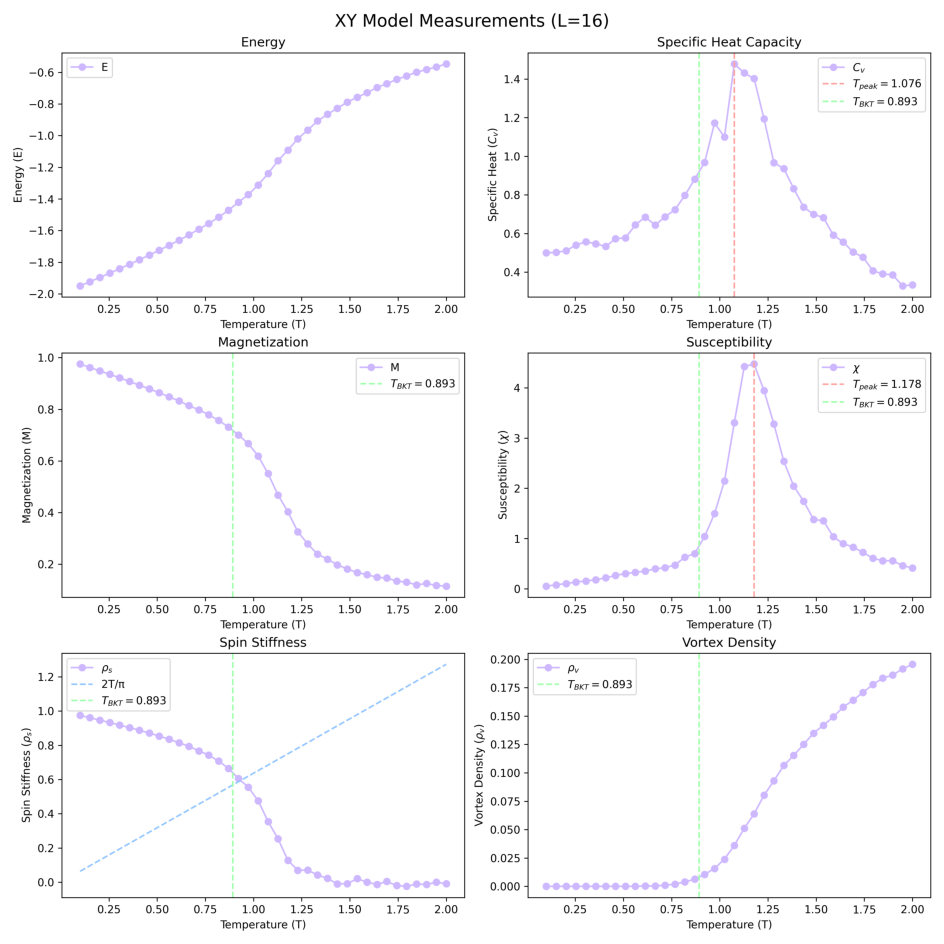

In [5]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [6]:
mc_config_results.keys()

dict_keys(['configs', 'labels', 'spend_time', 'params'])

In [7]:
xy_spin_config = mc_config_results['configs']
labels = mc_config_results['labels']
trash.append(mc_config_results)

xy_spin_config.shape

torch.Size([38, 990, 16, 16])

In [8]:
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)
xy_sampler = mc.XYModel(L=L, T=T, device=torch.device(device))
xy_sampler.spins = xy_spin_config

Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=38, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


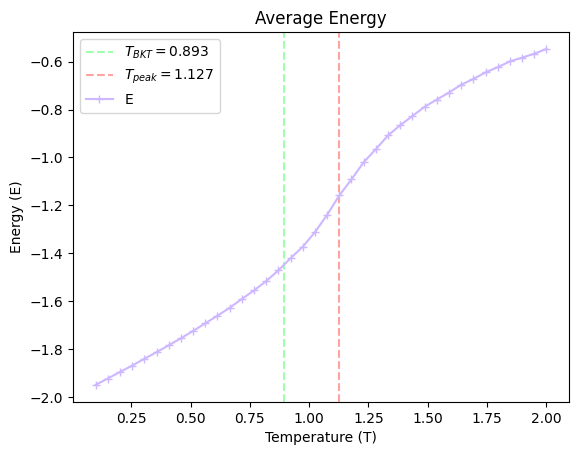

In [9]:
xy_sampler.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
)

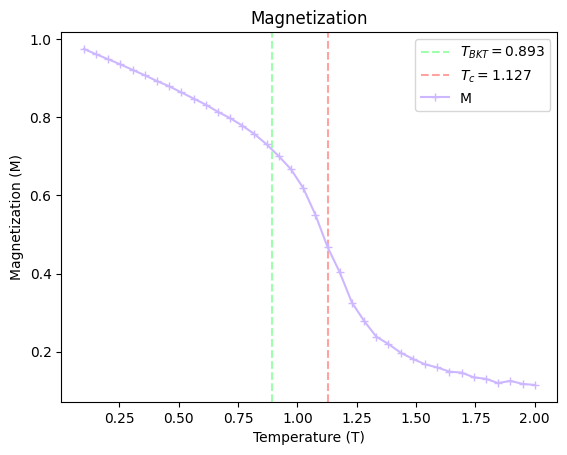

In [10]:
xy_sampler.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
)

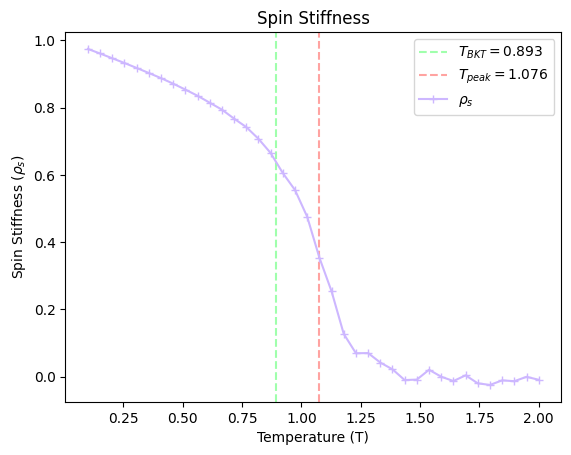

In [11]:
xy_sampler.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
)

In [12]:
trash.append(xy_sampler)
pf.clear_cuda_cache(trash)
trash = []

### Prepare the dataset

In [13]:
t_c = 1.0
tc_index = len(T[T < t_c])
tc_index

18

In [14]:
labels_selected = labels[:, 0]

transform = Compose([
    pfm.RandomRoll(max_shift=(L//2, L//2), p=0.5),
    RandomHorizontalFlip(p=0.9),
    RandomVerticalFlip(p=0.9),
])

xy_dataset = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
)

xy_dataset_sub_1 = mc.MCDataset(
    data=xy_spin_config[:tc_index, ...], 
    labels=labels_selected[:tc_index, ...],
)

xy_dataset_transform = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
    transform=transform,
)

xy_dataset_transform_sub_1 = mc.MCDataset(
    data=xy_spin_config[:tc_index, ...],
    labels=labels_selected[:tc_index, ...],
    transform=transform,
)

xy_dataset = ConcatDataset([xy_dataset, xy_dataset_transform,])
xy_dataset_sub_1 = ConcatDataset([xy_dataset_sub_1, xy_dataset_transform_sub_1,])

batch_size = 32

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
xy_dataloader_sub_1 = DataLoader(xy_dataset_sub_1, batch_size=batch_size, shuffle=True, num_workers=4)

In [15]:
model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'channel_mult': (4, 4,),
    'num_res_blocks': 1,
    'dropout': 0.0,
    'num_heads': 16,
    'num_groups': 4,
    'time_emb_dim': 16,
    'cond_emb_dims': (16,),
    'final_emb_dim': 4*16,
}

model = pfm.DiResUnet(**model_parameter_dict).to(device)

pf.check_model(model)

DiResUnet(
  (time_embedder): SinusoidalPosEmb()
  (time_mlp): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (cond_embedders): ModuleList(
    (0): SinusoidalPosEmb()
  )
  (cond_mlps): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (fusion_mlp): Linear(in_features=128, out_features=64, bias=True)
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (down_blocks): ModuleList(
    (0): ModuleList(
      (0): DiResBlock(
        (norm1): GroupNorm(4, 32, eps=1e-06, affine=False)
        (norm2): GroupNorm(4, 32, eps=1e-06, affine=False)
        (attn): Attention(
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (to_qkv_3): DConv(
            (depthwise): Conv2d(32, 32, kernel

### Prepare the save path

In [16]:
save_root = './'
save_folder_name = 'increase_sample_density_log'
pf.create_directory(root_path=save_root, folder_name=save_folder_name)
save_dir_root = Path(save_root) / save_folder_name

### Prepare the flow matching executor

In [17]:
gradient_accumulation_steps = 4

lr = gradient_accumulation_steps * 2e-4
# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
# init scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

fmex = pfm.CFMExecutor(
    save_dir_root=save_dir_root,
    model_params=model_parameter_dict,
    model=model,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-06-14 23:14:15,290 - INFO - Save directory root 'increase_sample_density_log' confirmed/created.
2025-06-14 23:14:15,294 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-06-14 23:14:15,295 - INFO - CFMExecutor initialized. Device: cuda:0
2025-06-14 23:14:15,295 - INFO - Save directory root: increase_sample_density_log
2025-06-14 23:14:15,296 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


### Train the model

#### Train the model by using Flow Matching

In [18]:
num_epochs = 7

In [19]:
fmex.train(
    train_loaders=(
        xy_dataloader,
        xy_dataloader_sub_1,
    ),
    num_epochs=num_epochs,
    save_every_epochs=1,
    gradient_accumulation_steps=gradient_accumulation_steps,
)

2025-06-14 23:14:15,422 - INFO - Total batches per epoch from all loaders: 3466
2025-06-14 23:14:15,422 - INFO - Effective batch size (approx, based on first loader): 128
2025-06-14 23:14:15,422 - INFO - Starting training for 7 epochs.
2025-06-14 23:14:15,422 - INFO - Gradient Accumulation Steps: 4
2025-06-14 23:17:27,977 - INFO - Epoch 1/7 completed in 192.55s.                                          
2025-06-14 23:17:27,977 - INFO -   Average Epoch Loss: 1.8489
2025-06-14 23:17:27,977 - INFO -   Optimizer steps in epoch: 867
2025-06-14 23:17:27,979 - INFO -   Last AutoClip threshold used: 1.9418
2025-06-14 23:17:27,979 - INFO -   LR scheduler stepped. New LR: 0.000800
2025-06-14 23:17:28,444 - INFO - Checkpoint saved successfully to increase_sample_density_log\checkpoints\checkpoint_epoch_0001.pth (Epoch 1)
2025-06-14 23:17:28,446 - INFO - ------------------------------------------------------------
2025-06-14 23:20:40,486 - INFO - Epoch 2/7 completed in 192.04s.                    

In [54]:
fmex.load_checkpoint(save_dir_root/f'checkpoints/checkpoint_epoch_{num_epochs:04d}.pth')

L = 16
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5

num_temp = int((Temp_end-Temp_start)//precision)+1 
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_evals=num_steps * 3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp, device=device) 
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32, device=device)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp,)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt, shuffle=False)

torch.cuda.empty_cache()
sol = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
)
torch.cuda.empty_cache()

2025-06-15 00:39:09,200 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-06-15 00:39:09,200 - INFO - Loaded checkpoint from increase_sample_density_log\checkpoints\checkpoint_epoch_0007.pth. Last completed epoch: 7.
2025-06-15 00:39:09,202 - INFO - Training will resume from epoch 8.
2025-06-15 00:39:09,203 - INFO -   Last recorded average epoch loss: 1.4892
2025-06-15 00:39:09,203 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'channel_mult': (4, 4), 'num_res_blocks': 1, 'dropout': 0.0, 'num_heads': 16, 'num_groups': 4, 'time_emb_dim': 16, 'cond_emb_dims': (16,), 'final_emb_dim': 64}
2025-06-15 00:39:09,240 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-06-15 00:39:09,242 - INFO - Starting sample generation (solving ODE)...
2025-06-15 00:39:09,242 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-06-15 00:39:09,243 - INFO -   Time Grid (Fixed Steps): [0.0, 

num_temp: 190
Optimal batch size: 154


2025-06-15 00:44:04,699 - INFO - Reshaped generated solutions tensor shape: torch.Size([190, 500, 16, 16])
2025-06-15 00:44:04,699 - INFO - Sample generation finished. Total samples: 95000.


In [55]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol
trash.append(sol)

Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


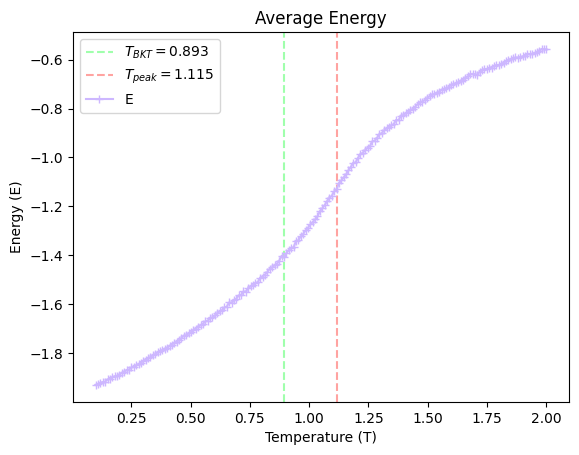

In [56]:
fm_energy = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)

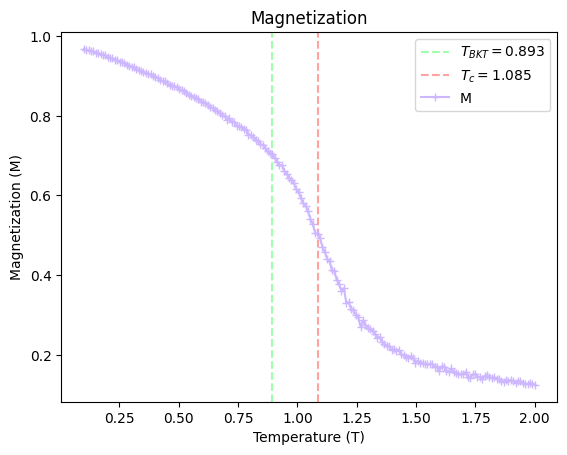

In [57]:
fm_magnetization = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)

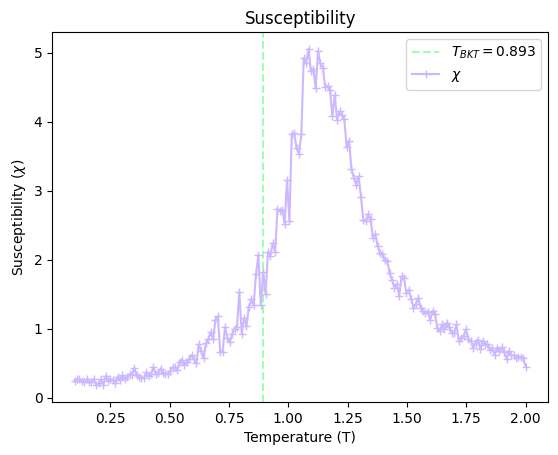

In [58]:
fm_suseptibility = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    return_observation=True
)

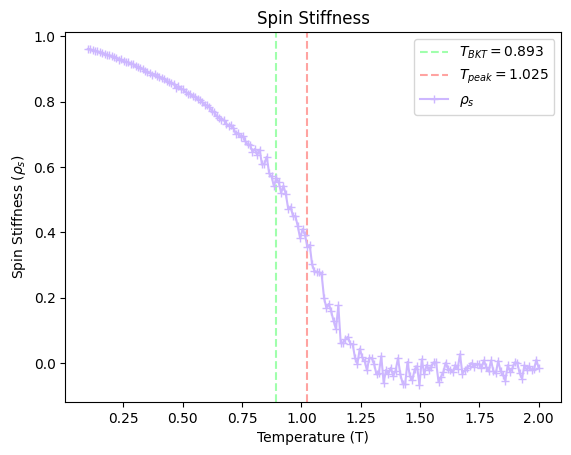

In [59]:
fm_stiffness = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)

### Compare the results between flow matching and Monte Carlo

In [60]:
mc_measure_results.keys()

dict_keys(['temperature', 'energy', 'specific_heat', 'magnetization', 'susceptibility', 'spin_stiffness', 'vortex_density'])

In [61]:
mc_temperature = mc_measure_results['temperature']
mc_energy = mc_measure_results['energy']
mc_magnetization = mc_measure_results['magnetization']
mc_susceptibility = mc_measure_results['susceptibility']
mc_stiffness = mc_measure_results['spin_stiffness']

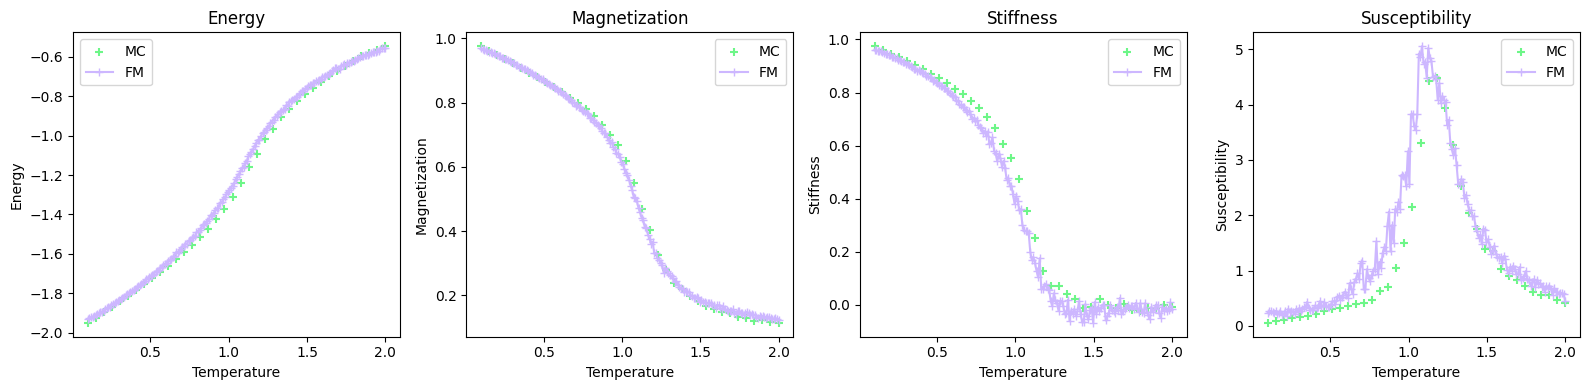

In [62]:
plt.style.use('seaborn-v0_8-pastel')

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_temperature, mc_energy, marker='+', label='MC', color="#6DF688")
ax[0].plot(Temp.cpu(), fm_energy, marker='+', linestyle='-', label='FM', color='#CDB7FF')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Energy')
ax[0].set_title('Energy')
ax[0].legend()
ax[1].scatter(mc_temperature, mc_magnetization, marker='+', label='MC', color="#6DF688")
ax[1].plot(Temp.cpu(), fm_magnetization, marker='+', linestyle='-', label='FM', color='#CDB7FF')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('Magnetization')
ax[1].set_title('Magnetization')
ax[1].legend()
ax[2].scatter(mc_temperature, mc_stiffness, marker='+', label='MC', color="#6DF688")
ax[2].plot(Temp.cpu(), fm_stiffness, marker='+', linestyle='-', label='FM', color='#CDB7FF')
ax[2].set_xlabel('Temperature')
ax[2].set_ylabel('Stiffness')
ax[2].set_title('Stiffness')
ax[2].legend()
ax[3].scatter(mc_temperature, mc_susceptibility, marker='+', label='MC', color="#6DF688")
ax[3].plot(Temp.cpu(), fm_suseptibility, marker='+', linestyle='-', label='FM', color='#CDB7FF')
ax[3].set_xlabel('Temperature')
ax[3].set_ylabel('Susceptibility')
ax[3].set_title('Susceptibility')
ax[3].legend()
plt.tight_layout()
plt.show()

In [63]:
torch.cuda.empty_cache()